# Result processing

# Results from binary classifier

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
import pickle

In [62]:
def visualize_classifier(classifier_info):
    """
    Compare two masks to check how they differ.
    images: first mask, second mask, and the difference between them.
    
    Args:
        predicted_mask (list): The first mask to compare.
        real_mask (list): The second mask to compare.
    """
    # using matplotlib to visualize the masks
    predicted_mask = classifier_info['predicted_mask']
    real_mask = classifier_info['mask']
    seed = classifier_info['seed']
    noise = classifier_info['noise_type']
    window = classifier_info['window_type']
    accuracy = classifier_info['accuracy']
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Classifier {seed} {noise} {window}, Accuracy: {accuracy:.4f}')
    ax1.imshow(predicted_mask, cmap='gray')
    ax1.set_title(f'Predicted Mask')
    ax1.axis('off')
    ax2.imshow(real_mask, cmap='gray')
    ax2.set_title('Real Mask')
    ax2.axis('off')
    ax3.imshow(abs(real_mask - predicted_mask), cmap='gray') # might not be totally correct TODO (one sided difference)
    ax3.set_title('Absolute Difference')
    ax3.axis('off')
    plt.show()

Classifier 1 - Seed: 2291659237, Noise Type: vertical_noise, Window Type: window_3x3


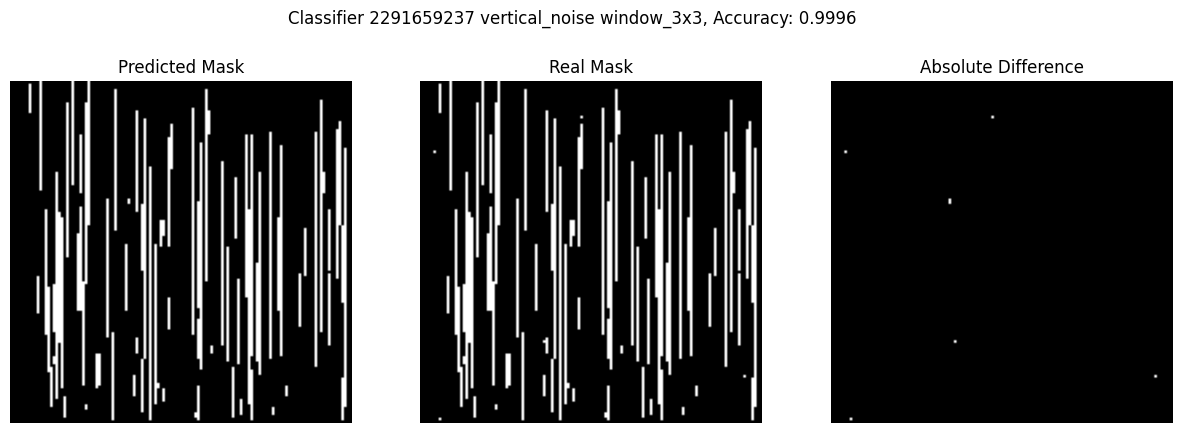

Classifier 2 - Seed: 2441695047, Noise Type: diagonal_noise, Window Type: window_3x3


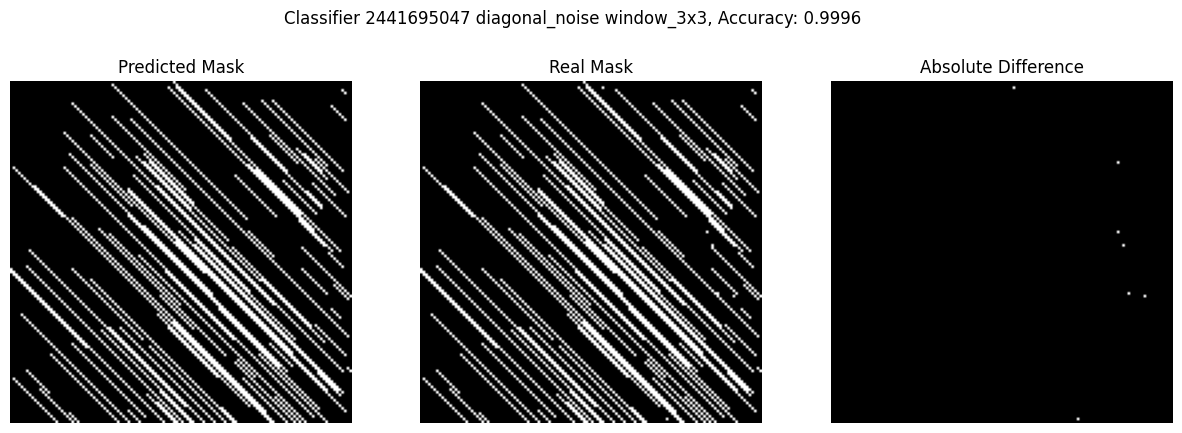

Classifier 3 - Seed: 2440749822, Noise Type: periodic_noise, Window Type: window_3x3


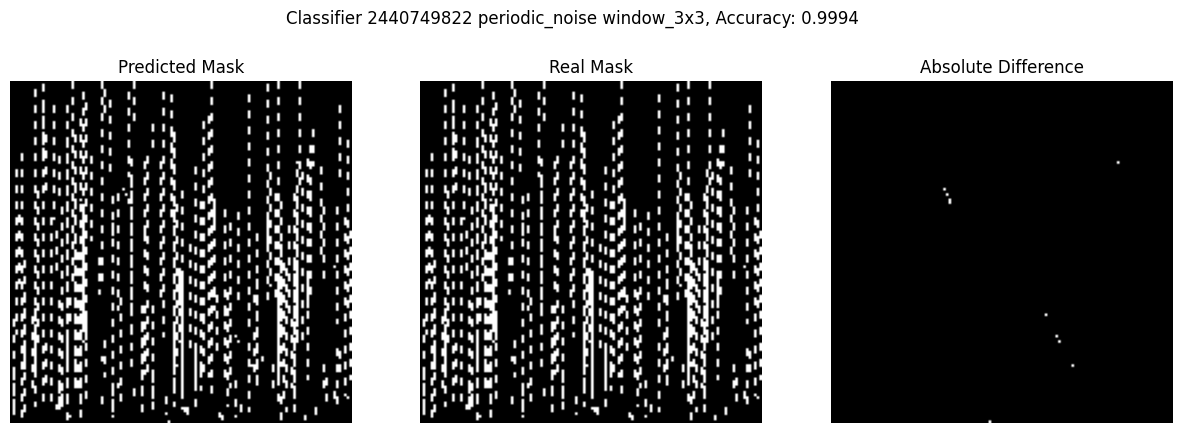

Classifier 4 - Seed: 2802942914, Noise Type: sap_noise, Window Type: window_3x3


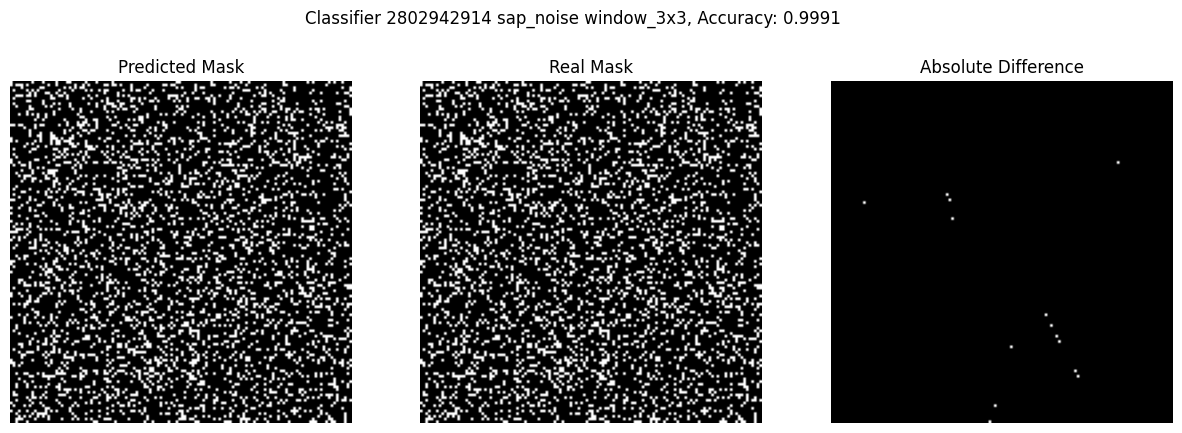

In [63]:
# import all results from results directory

classifier_stats_header = ['seed', 'noise_type', 'window_type', 'mutation_rate', 'total_evaluations', 'accuracy', 'precision', 'recall']
def import_top_results(results_dir):
    top_results = []

    classifier_results_summary = pd.read_csv(os.path.join(results_dir, 'classifier_stats.csv'), names=classifier_stats_header)
    top_vertical = classifier_results_summary[classifier_results_summary["noise_type"] == "vertical_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_diagonal = classifier_results_summary[classifier_results_summary["noise_type"] == "diagonal_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_periodic = classifier_results_summary[classifier_results_summary["noise_type"] == "periodic_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    top_sap = classifier_results_summary[classifier_results_summary["noise_type"] == "sap_noise"].nlargest(1, 'accuracy')['seed'].values[0]
    for top_result_seed in [top_vertical, top_diagonal, top_periodic, top_sap]:
        # load the corresponding mask
        top_result_row = classifier_results_summary[classifier_results_summary['seed'] == top_result_seed]
        noise_type = top_result_row['noise_type'].values[0]
        window_type = top_result_row['window_type'].values[0]
        accuracy = top_result_row['accuracy'].values[0]

        filename = f"results_classifier_{noise_type}_{window_type}_{top_result_seed}.pkl"
        result_detail = pickle.load(open(os.path.join(results_dir, filename), 'rb'))
        
        pred_mask = result_detail['pred_mask']
        mask = result_detail['mask']
        top_results.append({
            'seed': top_result_seed,
            'noise_type': noise_type,
            'window_type': window_type,
            'predicted_mask': pred_mask,
            'accuracy': accuracy,
            'mask': mask
        })
    return top_results


top_results = import_top_results('results')
for i in range(len(top_results)):
    # compare the predicted mask with the ground truth mask
    print(f"Classifier {i+1} - Seed: {top_results[i]['seed']}, Noise Type: {top_results[i]['noise_type']}, Window Type: {top_results[i]['window_type']}")
    visualize_classifier(top_results[i])

## Results from image filtering

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pickle
from scipy.ndimage import median_filter
import seaborn as sns

In [65]:
def compare_images(filter_info):
    filtered = filter_info['filtered_image']
    original = filter_info['original_image']
    noised = filter_info['noised_image']
    window_type = filter_info['window_type']
    noise_type = filter_info['noise_type']
    median_filtered_image = filter_info['median_filtered_image']
    seed = filter_info['seed']
    # using matplotlib to visualize the images
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Filter {seed} {noise_type} {window_type}')
    ax1.imshow(noised, cmap='gray')
    ax1.set_title(f'Noised Image')
    ax1.axis('off')
    ax2.imshow(median_filtered_image, cmap='gray')
    ax2.set_title('Median Filtered Image')
    ax2.axis('off')
    ax3.imshow(filtered, cmap='gray')
    ax3.set_title(f'Filtered Image {seed}')
    ax3.axis('off')
    ax4.imshow(original, cmap='gray')
    ax4.set_title('Original Image')
    ax4.axis('off')
    plt.show()

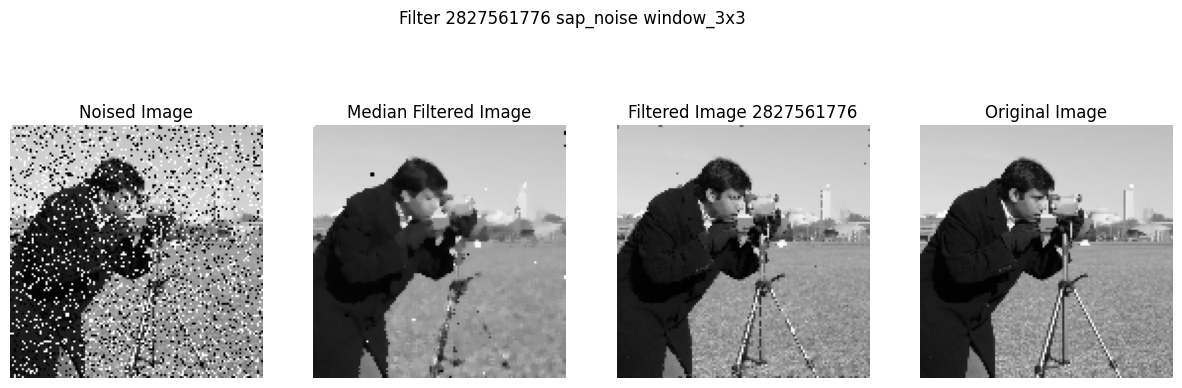

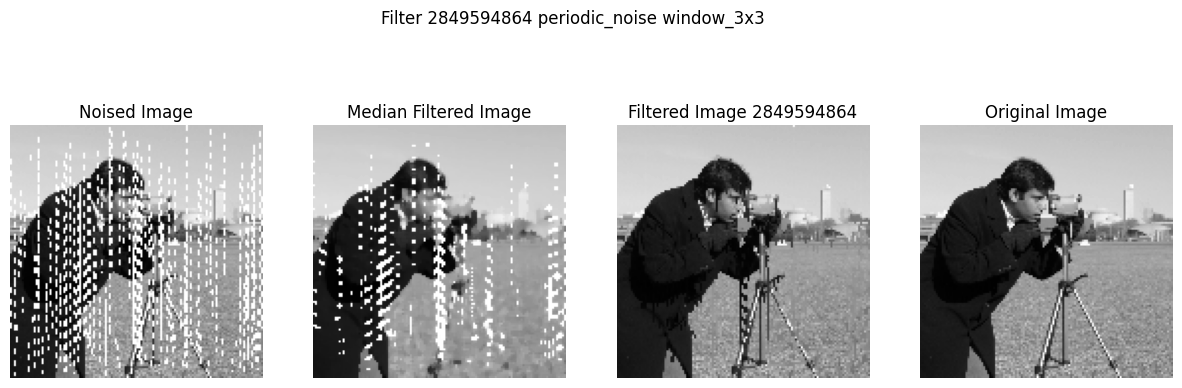

In [66]:
filter_stats_header = ['seed', 'noise_type', 'window_type', 'classifier_seed', 'mutation_rate', 'total_evaluations', 'fitness']

# TODO Temporary solution, waiting for all filter results to be generated 
noise_types = ['sap_noise', 'periodic_noise']
windows_per_noise = {
    'sap_noise': ['window_3x3'],
    'periodic_noise': ['window_3x3']
    }
# change values after all filter results are generated
def import_top_filter_results(results_dir):
    top_result_seeds = []
    top_results = []
    filter_results_summary = pd.read_csv(os.path.join(results_dir, 'filter_stats.csv'), names=filter_stats_header)
    for noise_type in noise_types:
        for window_type in windows_per_noise[noise_type]:
            top_result_per_noise_window = filter_results_summary.query(
                                                                    f'noise_type == "{noise_type}" and window_type == "{window_type}"'
                                                                    ).nlargest(1, 'fitness')['seed'].values[0]
            top_result_seeds.append(top_result_per_noise_window)
    
    for top_result_seed in top_result_seeds:
        # load the corresponding mask
        top_result_row = filter_results_summary[filter_results_summary['seed'] == top_result_seed]
        noise_type = top_result_row['noise_type'].values[0]
        window_type = top_result_row['window_type'].values[0]
        fitness = top_result_row['fitness'].values[0]

        filename = f"results_filter_{noise_type}_{window_type}_{top_result_seed}.pkl"
        result_detail = pickle.load(open(os.path.join(results_dir, filename), 'rb'))
        
        filtered_image = result_detail['filtered_image']
        original_image = result_detail['original_image']
        noised_image = result_detail['noised_image']
        median_filtered_image = median_filter(noised_image, size=(3, 3))
        top_results.append({
            'seed': top_result_seed,
            'noise_type': noise_type,
            'window_type': window_type,
            'filtered_image': filtered_image,
            'fitness': fitness,
            'original_image': original_image,
            'noised_image': noised_image,
            'median_filtered_image': median_filtered_image
        })
    return top_results

results = import_top_filter_results('results')
for i in range(len(results)):
    # compare the predicted mask with the ground truth mask
    compare_images(results[i])

## Porovnání oken

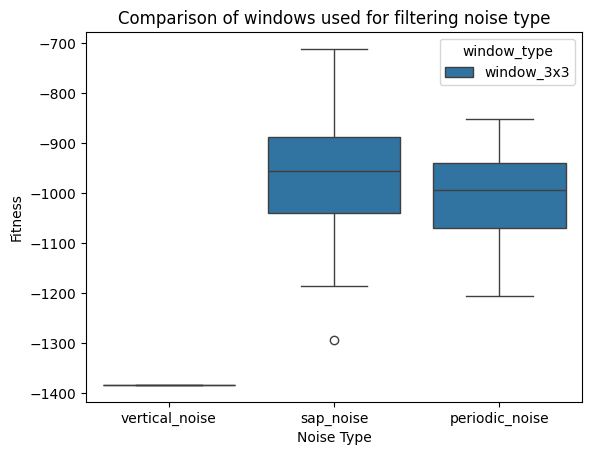

In [67]:
def plot_filter_window_comparison_boxplots():
    filter_results_summary = pd.read_csv(os.path.join('results', 'filter_stats.csv'), names=filter_stats_header)
    # plot the boxplot
    sns.boxplot(x='noise_type', y='fitness', hue='window_type', data=filter_results_summary)
    plt.title(f'Comparison of windows used for filtering noise type')
    plt.xlabel('Noise Type')
    plt.ylabel('Fitness')
    plt.show()

plot_filter_window_comparison_boxplots()